# Feature Engineering and Model Training

In this notebook we will develop our prediction model for both the Bull market and the Bear market

In [1]:
# Initialize notebook and define libraries
import pandas as pd
from datetime import datetime
import math
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from scipy.stats import loguniform
from sklearn.model_selection import RandomizedSearchCV

%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')

## Key Functions

### Feature Engineering

The feature engineering section aims to transform and categorize numerical data into meaningful indicators that capture market conditions during bull and bear markets. Through various transformations, the goal is to identify buying and selling opportunities based on different market indicators like returns, RSI, and long/short ratios.

In [2]:
#bull market corresponds to the year before, the year of and the one year after halving
#bear market corresponds to two years after halving

bullmarket = pd.date_range(start='01/01/2023', end='12/31/2025', freq='D')
bearmarket = pd.date_range(start='01/01/2022', end='12/31/2022', freq='D')

In [3]:
def one_deviation(data, column, bound):
    if bound == 0:
        return np.mean(data[column])-1*np.std(data[column])
    else:
        return np.mean(data[column])+1*np.std(data[column])


def two_deviation(data, column):
    return np.mean(data[column])+2*np.std(data[column])


def transformation(data):

    """
    Applies transformations to the input DataFrame. Converts Numerical features into categorical features

    Parameters:
    - data (DataFrame): Input dataframe containing numerical features

    Returns:
    - data (DataFrame): Transformed data containing categorical features

    The market conditions are determined for both 'bullmarket' and 'bearmarket' scenarios, and specific thresholds
    are used for each indicator to determine the transformation values. Additionally, helper functions like
    'one_deviation' and 'two_deviation' are used for calculating deviations in 'BTC LSR', 'Total Long Liquid', and
    'Total Short Liquid'.

    1 : presents a buy opportunity
    -1 : presents a sell opportunity
    0 : no clear opportunity defined

    """

    data['wmrs_transformed'] = 0                                        #initializes the column containing all zeros
    for index, row in data.iterrows():
        if index in bullmarket and row['Weekly Median Returns'] < -20: #buying opportunity in bullmarket arises when median returns fall below 20
            data.loc[index, 'wmrs_transformed'] = 1
        elif index in bearmarket and row['Weekly Median Returns'] > 20:  #selling opportunity in bearmarket arises when median returns rise above 20
            data.loc[index, 'wmrs_transformed'] = -1

    data['rsi_transformed'] = 0                                         #initializes the column containing all zeros
    for index, row in data.iterrows():
        if index in bullmarket and row['Median RSI'] < 30:              #buying opportunity in bullmarket arises when RSI enters oversold territory
            data.loc[index, 'rsi_transformed'] = 1
        elif index in bearmarket and row['Median RSI'] > 70:            #selling opportunity in bearmarket arises when RSI enters overbought territory
            data.loc[index, 'rsi_transformed'] = -1

    data['lsr_transformed'] = 0                                         #initializes the column containing all zeros
    for index, row in data.iterrows():
        if index in bullmarket and row['BTC LSR'] > one_deviation(data, 'BTC LSR', 1):  #buying opportunity in bullmarket arises when long/short ratio exceeds one standard deviation above the mean
            data.loc[index, 'lsr_transformed'] = 1
        elif index in bearmarket and row['BTC LSR'] < one_deviation(data, 'BTC LSR', 0): #selling opportunity in bearmarket arises when long/short ratio exceeds one standard deviation below the mean
            data.loc[index, 'lsr_transformed'] = -1

    data['longliqs_transformed'] = 0                                    #initializes the column containing all zeros
    for index, row in data.iterrows():
        if index in bullmarket and row['Total Long Liquid'] > two_deviation(data,'Total Long Liquid'):  #buying opportunity in bullmarket arises when total long liquidations exceeds two standard deviations above the mean
            data.loc[index, 'longliqs_transformed'] = 1

    data['shortliqs_transformed'] = 0                                   #initializes the column containing all zeros
    for index, row in data.iterrows():
        if index in bearmarket and row['Total Short Liquid'] > two_deviation(data,'Total Short Liquid'): #selling opportunity in bearmarket arises when total short liquidations exceeds two standard deviations above the mean
            data.loc[index, 'shortliqs_transformed'] = -1

    return data

### Model Training

In the model training phase, the objective is to build and optimize Random Forest classifiers for both bull and bear markets. The models utilize selected features to predict market actions (buy, sell, or hold). Parameter tuning is performed to enhance model performance, and the resulting classifiers are evaluated on training and test datasets.

In [4]:
def feature_selection_bull(data):
    include = ['Median EMA','Diff SMA','Meme Volume Ratio','BTC Open Interest',
              'BTC Weekly Returns',
              'wmrs_transformed','rsi_transformed','lsr_transformed','longliqs_transformed','shortliqs_transformed']
    X = data[include]
    y = data['Action']
    change = data['Percent Change']
    return X, y, change


def feature_selection_bear(data):
    include = ['Median EMA','Diff SMA','Meme Volume Ratio','BTC Open Interest',
              'BTC Weekly Returns',
              'wmrs_transformed','rsi_transformed','lsr_transformed','longliqs_transformed','shortliqs_transformed']
    X = data[include]
    y = data['Action']
    change = data['Percent Change']
    return X, y, change


def print_importance(model, X):
    feature_importances = model.feature_importances_
    feature_names = X.columns
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    print(feature_importance_df)

## Feature Engineering

In [5]:
#Cleaning our data from Notebook 2
cleaned = pd.read_csv('wrangled.csv',index_col=0)
cleaned.index = pd.DatetimeIndex(cleaned.index)
cleaned.head()

,Weekly Median Returns,BTC Weekly Returns,BTC Close,Median RSI,BTC RSI,Total Long Liquid,Total Short Liquid,Meme Volume Ratio,BTC SMA,Diff SMA,Total Open Interest,BTC Open Interest,OI Ratio,Mean LSR,BTC LSR,Median FR,BTC FR,Median EMA,BTC EMA
t,,,,,,,,,,,,,,,,,,,
2022-01-09,-16.463085,-11.482191,41851.22,16.214313,4.936665,1.722586,1.871387,0.481659,46853.5480,-10.676519,4.536014,0.102128,44.414874,4.093668,2.9793,10.9575,10.957500,2.099449,43261.179144
2022-01-10,-19.907214,-9.999309,41801.55,13.922615,4.896290,6.360438,2.758649,0.381020,46499.8680,-10.103938,4.984904,0.105966,47.042506,3.671095,2.8329,10.9575,10.957500,2.067494,42992.427489
2022-01-11,-14.507639,-6.835056,42700.68,25.431213,17.160621,1.370350,2.972028,0.863178,46206.4175,-7.587123,5.089135,0.114105,44.600639,3.945355,2.6417,10.9575,10.957500,2.074618,42941.306428
2022-01-12,-2.718220,1.057144,43880.72,34.971047,29.151507,1.043282,2.913580,1.369731,45859.5575,-4.314995,5.381825,0.115040,46.782262,3.360678,1.9674,10.9575,-5.853497,2.087305,43099.295685
2022-01-13,-6.214846,-1.266690,42534.32,31.612051,25.019424,4.586022,2.238563,1.560806,45445.8460,-6.406583,5.484570,0.108685,50.463020,3.373897,2.3602,10.9575,-6.663256,2.080232,43007.478269


In [6]:
full = transformation(cleaned.copy())
full.head()

,Weekly Median Returns,BTC Weekly Returns,BTC Close,Median RSI,BTC RSI,Total Long Liquid,Total Short Liquid,Meme Volume Ratio,BTC SMA,Diff SMA,...,BTC LSR,Median FR,BTC FR,Median EMA,BTC EMA,wmrs_transformed,rsi_transformed,lsr_transformed,longliqs_transformed,shortliqs_transformed
t,,,,,,,,,,,,,,,,,,,,,
2022-01-09,-16.463085,-11.482191,41851.22,16.214313,4.936665,1.722586,1.871387,0.481659,46853.5480,-10.676519,...,2.9793,10.9575,10.957500,2.099449,43261.179144,0,0,0,0,0
2022-01-10,-19.907214,-9.999309,41801.55,13.922615,4.896290,6.360438,2.758649,0.381020,46499.8680,-10.103938,...,2.8329,10.9575,10.957500,2.067494,42992.427489,0,0,0,0,0
2022-01-11,-14.507639,-6.835056,42700.68,25.431213,17.160621,1.370350,2.972028,0.863178,46206.4175,-7.587123,...,2.6417,10.9575,10.957500,2.074618,42941.306428,0,0,0,0,0
2022-01-12,-2.718220,1.057144,43880.72,34.971047,29.151507,1.043282,2.913580,1.369731,45859.5575,-4.314995,...,1.9674,10.9575,-5.853497,2.087305,43099.295685,0,0,0,0,0
2022-01-13,-6.214846,-1.266690,42534.32,31.612051,25.019424,4.586022,2.238563,1.560806,45445.8460,-6.406583,...,2.3602,10.9575,-6.663256,2.080232,43007.478269,0,0,0,0,0


## Target Setting

The distribution of 5 day rolling returns for Bitcoin follows a  normal distribution with the majority of returns falling within positive and negative 2 percent. Therefore, the threshold that will be established to differentiate between when to buy, sell, or hold will be 2%. This is favorable because it results in a fairly balanced distribution between buying, selling, and holding.

In [7]:
# Calculate percentage change for the target variable
full['Percent Change'] = (full['BTC Close'].shift(-5) / full['BTC Close'] -1)*100
full = full.dropna()
full.head()

,Weekly Median Returns,BTC Weekly Returns,BTC Close,Median RSI,BTC RSI,Total Long Liquid,Total Short Liquid,Meme Volume Ratio,BTC SMA,Diff SMA,...,Median FR,BTC FR,Median EMA,BTC EMA,wmrs_transformed,rsi_transformed,lsr_transformed,longliqs_transformed,shortliqs_transformed,Percent Change
t,,,,,,,,,,,,,,,,,,,,,
2022-01-09,-16.463085,-11.482191,41851.22,16.214313,4.936665,1.722586,1.871387,0.481659,46853.5480,-10.676519,...,10.9575,10.957500,2.099449,43261.179144,0,0,0,0,0,2.846225
2022-01-10,-19.907214,-9.999309,41801.55,13.922615,4.896290,6.360438,2.758649,0.381020,46499.8680,-10.103938,...,10.9575,10.957500,2.067494,42992.427489,0,0,0,0,0,3.035677
2022-01-11,-14.507639,-6.835056,42700.68,25.431213,17.160621,1.370350,2.972028,0.863178,46206.4175,-7.587123,...,10.9575,10.957500,2.074618,42941.306428,0,0,0,0,0,0.843031
2022-01-12,-2.718220,1.057144,43880.72,34.971047,29.151507,1.043282,2.913580,1.369731,45859.5575,-4.314995,...,10.9575,-5.853497,2.087305,43099.295685,0,0,0,0,0,-3.884120
2022-01-13,-6.214846,-1.266690,42534.32,31.612051,25.019424,4.586022,2.238563,1.560806,45445.8460,-6.406583,...,10.9575,-6.663256,2.080232,43007.478269,0,0,0,0,0,-0.462544


Text(0, 0.5, 'Probability of Price Change')

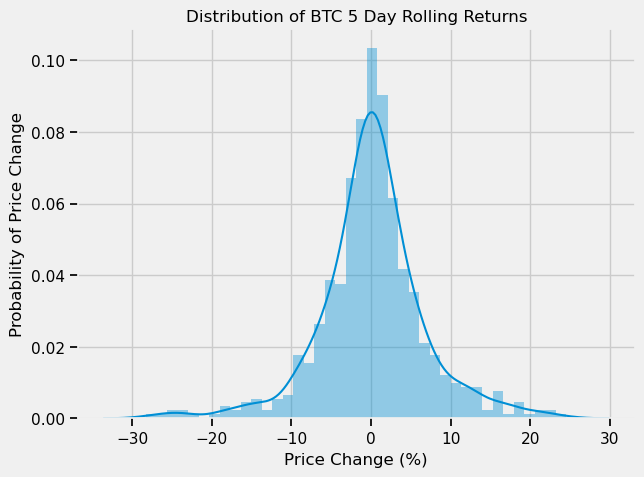

In [8]:
plt.title('Distribution of BTC 5 Day Rolling Returns')
sns.distplot(full['Percent Change'])
plt.xlabel('Price Change (%)')
plt.ylabel('Probability of Price Change')

Looking at our training data above, lets decide on a split for our buy, sell and hold criteria

In [9]:
# Criteria for Actions
buy = 2
sell = -2

full['Action'] = [1 if change > buy else -1 if change < sell else 0 for change in full['Percent Change']]

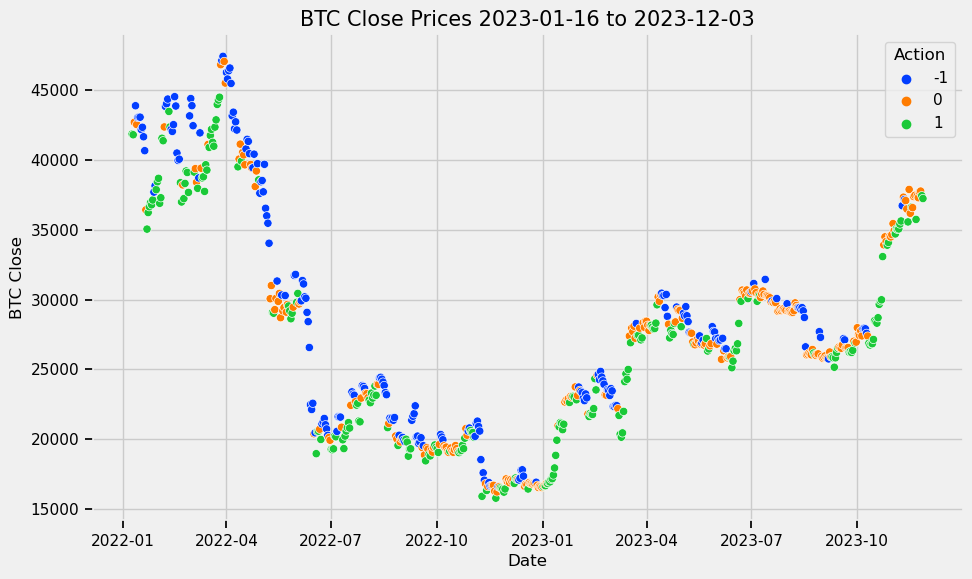

In [10]:
plt.figure(figsize=(10,6))
ax = sns.scatterplot(data = full, x=full.index, y='BTC Close', hue='Action',palette='bright')

plt.title('BTC Close Prices 2023-01-16 to 2023-12-03',fontsize=15)
plt.xlabel('Date',fontsize=12)
plt.ylabel('BTC Close',fontsize=12)
plt.show()

Looking at how our predictions did, we can see exactly when to perfor eac action. Now we need to separate our bull and bear markets for model training

In [11]:
# Filter rows based on date ranges
bull = full[full.index.isin(bullmarket)]
bear = full[full.index.isin(bearmarket)]

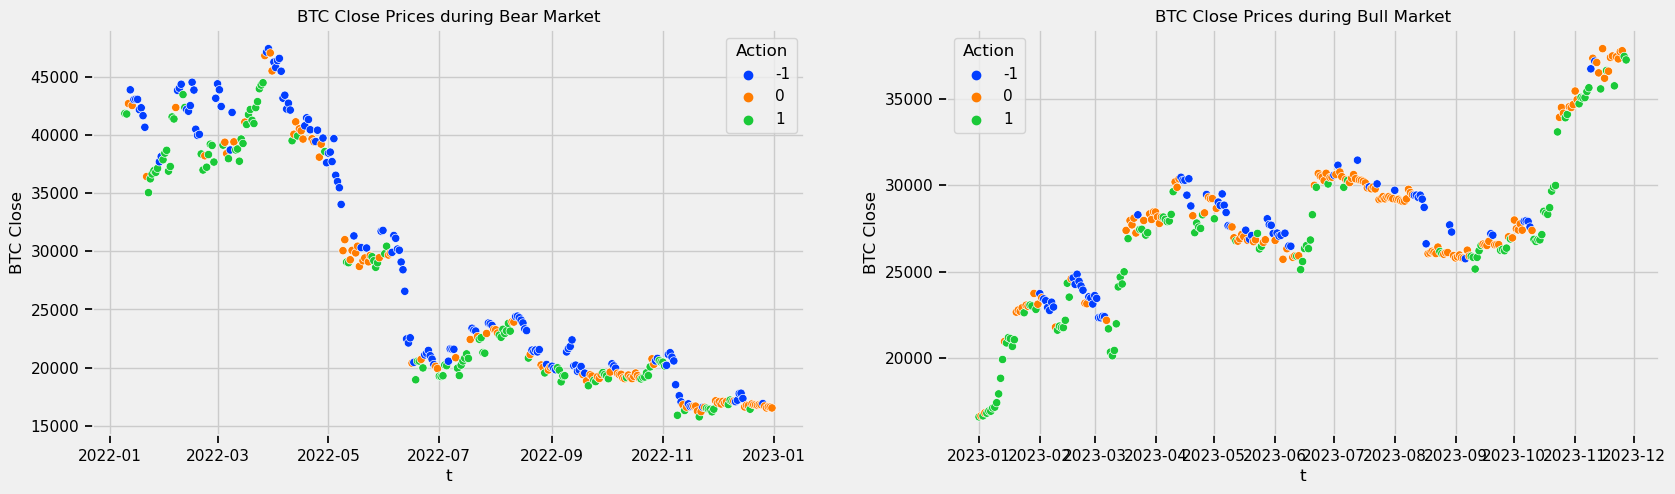

In [12]:
# Create grid of figures
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Daytime activity plots
sns.scatterplot(data=bear, x=bear.index, y='BTC Close', hue='Action', palette='bright', ax=axes[0])
axes[0].set_title('BTC Close Prices during Bear Market')

sns.scatterplot(data=bull, x=bull.index, y='BTC Close', hue='Action', palette='bright', ax=axes[1])
axes[1].set_title('BTC Close Prices during Bull Market')

plt.show()

In [13]:
bull.head()

,Weekly Median Returns,BTC Weekly Returns,BTC Close,Median RSI,BTC RSI,Total Long Liquid,Total Short Liquid,Meme Volume Ratio,BTC SMA,Diff SMA,...,BTC FR,Median EMA,BTC EMA,wmrs_transformed,rsi_transformed,lsr_transformed,longliqs_transformed,shortliqs_transformed,Percent Change,Action
t,,,,,,,,,,,,,,,,,,,,,
2023-01-01,-3.459282,-1.272557,16610.3,38.656317,46.354800,1.437153,1.367094,1.319229,16848.295,-1.412576,...,0.757163,0.397827,16720.127664,0,0,0,0,0,2.007790,1
2023-01-02,-2.584819,-1.459832,16666.0,51.852324,58.453520,1.739699,5.556643,0.913522,16792.740,-0.754731,...,2.925652,0.397696,16712.910642,0,0,0,0,0,1.623065,0
2023-01-03,-1.944837,-0.185649,16667.2,40.104563,38.344988,1.159093,3.322215,0.767403,16735.905,-0.410525,...,3.640081,0.396350,16706.815890,0,0,0,0,0,2.744912,1
2023-01-04,4.919423,1.832638,16842.1,50.080002,51.070307,1.292815,8.166948,0.812140,16710.420,0.788011,...,5.403143,0.395770,16724.853771,0,0,0,0,0,1.945126,0
2023-01-05,4.627174,1.163539,16823.8,48.431653,50.389562,1.478747,1.663476,2.578255,16720.405,0.618376,...,7.959528,0.394974,16738.046601,0,0,0,0,0,3.596096,1


In [14]:
bear.head()

,Weekly Median Returns,BTC Weekly Returns,BTC Close,Median RSI,BTC RSI,Total Long Liquid,Total Short Liquid,Meme Volume Ratio,BTC SMA,Diff SMA,...,BTC FR,Median EMA,BTC EMA,wmrs_transformed,rsi_transformed,lsr_transformed,longliqs_transformed,shortliqs_transformed,Percent Change,Action
t,,,,,,,,,,,,,,,,,,,,,
2022-01-09,-16.463085,-11.482191,41851.22,16.214313,4.936665,1.722586,1.871387,0.481659,46853.5480,-10.676519,...,10.957500,2.099449,43261.179144,0,0,0,0,0,2.846225,1
2022-01-10,-19.907214,-9.999309,41801.55,13.922615,4.896290,6.360438,2.758649,0.381020,46499.8680,-10.103938,...,10.957500,2.067494,42992.427489,0,0,0,0,0,3.035677,1
2022-01-11,-14.507639,-6.835056,42700.68,25.431213,17.160621,1.370350,2.972028,0.863178,46206.4175,-7.587123,...,10.957500,2.074618,42941.306428,0,0,0,0,0,0.843031,0
2022-01-12,-2.718220,1.057144,43880.72,34.971047,29.151507,1.043282,2.913580,1.369731,45859.5575,-4.314995,...,-5.853497,2.087305,43099.295685,0,0,0,0,0,-3.884120,-1
2022-01-13,-6.214846,-1.266690,42534.32,31.612051,25.019424,4.586022,2.238563,1.560806,45445.8460,-6.406583,...,-6.663256,2.080232,43007.478269,0,0,0,0,0,-0.462544,0


Sell Percent: 0.22
Hold Percent: 0.45
Buy Percent: 0.33


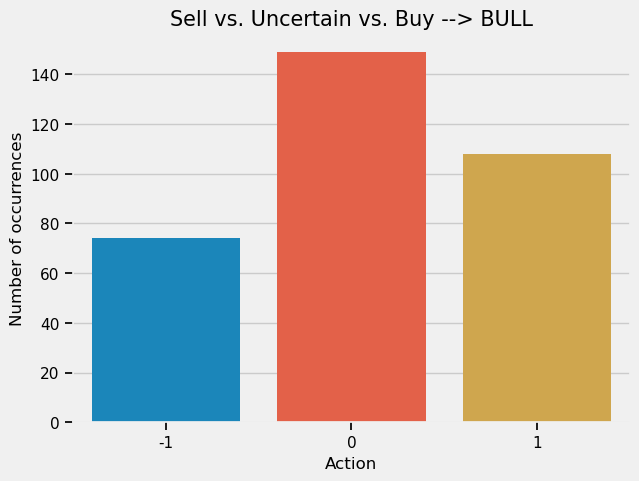

In [15]:
plt.title('Sell vs. Uncertain vs. Buy --> BULL',fontsize=15)
sns.countplot(data=bull, x='Action')
plt.ylabel('Number of occurrences')

print('Sell Percent: {:.2f}'.format((bull['Action']==-1).sum()/len(bull['Action'])))
print('Hold Percent: {:.2f}'.format((bull['Action']==0).sum()/len(bull['Action'])))
print('Buy Percent: {:.2f}'.format((bull['Action']==1).sum()/len(bull['Action'])))

Sell Percent: 0.38
Hold Percent: 0.29
Buy Percent: 0.32


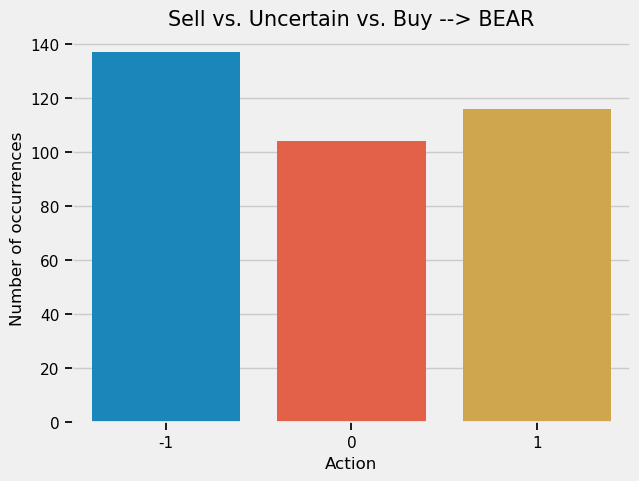

In [16]:
plt.title('Sell vs. Uncertain vs. Buy --> BEAR',fontsize=15)
sns.countplot(data=bear, x='Action')
plt.ylabel('Number of occurrences')

print('Sell Percent: {:.2f}'.format((bear['Action']==-1).sum()/len(bear['Action'])))
print('Hold Percent: {:.2f}'.format((bear['Action']==0).sum()/len(bear['Action'])))
print('Buy Percent: {:.2f}'.format((bear['Action']==1).sum()/len(bear['Action'])))

# Model Training

Under Model Evaluation, the focus is on assessing the performance of the trained models in predicting market actions during bull and bear markets. The goal is to compare the model returns against a benchmark strategy of buy and hold, providing insights into the effectiveness of the machine learning approach in making informed trading decisions.

## Bull Model Training

In [17]:
Xbull, ybull, changebull = feature_selection_bull(bull)

xtrain, xtest, ytrain, ytest, changetrain, changetest = train_test_split(Xbull,ybull,changebull,
                                                        train_size=0.7, random_state=0,shuffle=False)

In [18]:
xtest.index[1]

Timestamp('2023-08-21 00:00:00')

In [19]:
# Initialize the model first in order to perform parameter hypertuning
model = RandomForestClassifier()
model.fit(xtrain,ytrain)

RandomForestClassifier()

### Parameter Hypertuning

In [20]:
#Using random search to find which hyperparameters to tune to improve our model
tscv = TimeSeriesSplit(n_splits=10)

param_distributions = {'criterion': ('gini', 'entropy', 'log_loss'),
                       'max_depth': (15,25,35,50),
                       'max_features': ('sqrt','log2',None),
                       'max_samples': (0.6,0.7,0.8,0.9),
                       'min_samples_leaf': (1, 2, 3, 4),
                       'min_samples_split':(2, 4, 6, 8),
                       'class_weight': ({1:0.25,0:0.5,-1:0.25}, {1:0.25,0:0.45,-1:0.3},None)}

rs = RandomizedSearchCV(estimator=model,
                        param_distributions=param_distributions,
                        n_iter=200,
                        scoring='accuracy',
                        cv=tscv)

#rs.fit(xtrain, ytrain)

In [22]:
model_final = RandomForestClassifier(n_estimators=99,
                                     min_samples_split=4,
                                     min_samples_leaf=2,
                                     max_samples=0.8,
                                     max_features=None,
                                     max_depth=15,
                                     class_weight = {1:0.25,0:0.45,-1:0.35},
                                     criterion= 'entropy',
                                     bootstrap = True)
model_final.fit(xtrain, ytrain)

RandomForestClassifier(class_weight={-1: 0.35, 0: 0.45, 1: 0.25},
                       criterion='entropy', max_depth=15, max_features=None,
                       max_samples=0.8, min_samples_leaf=2, min_samples_split=4,
                       n_estimators=99)

In [23]:
print_importance(model_final, xtrain)

                 Feature  Importance
0             Median EMA    0.307337
4     BTC Weekly Returns    0.194378
1               Diff SMA    0.188044
3      BTC Open Interest    0.175386
2      Meme Volume Ratio    0.122692
7        lsr_transformed    0.006082
6        rsi_transformed    0.003612
8   longliqs_transformed    0.002469
5       wmrs_transformed    0.000000
9  shortliqs_transformed    0.000000


Knowing what feature's perfome best will help us iterate for the model

### Accuracy Score

In [24]:
#train data
ytrain_pred = model_final.predict(xtrain)
print(accuracy_score(ytrain, ytrain_pred))

0.9437229437229437


In [25]:
#test data
ytest_pred = model_final.predict(xtest)
print(accuracy_score(ytest, ytest_pred))

0.49


### Profit Check

For this specific situation, it is not sufficient to assess the model solely based on conventional metrics such as accuracy. For that reason, each model is evaluated based on its profitability on the test data relative to a benchmark performance of simply buying and holding.

949.4200948030373


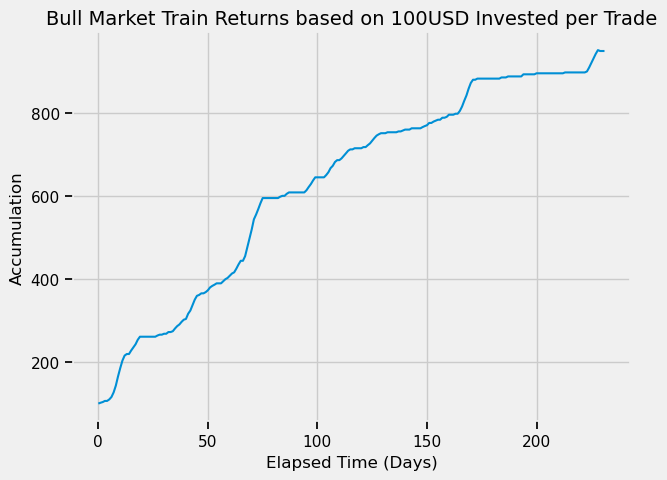

In [26]:
principal = 100
per_trade = 100
stance = [principal]
for i in range(len(changetrain)):
    if ytrain_pred[i]==1:
        profit = changetrain[i]
        principal += per_trade*profit/100
        stance.append(principal)
    elif ytrain_pred[i]==-1:
        profit = -changetrain[i]
        principal+= per_trade*profit/100
        stance.append(principal)
    else:
        stance.append(principal)

print(principal)
plt.title('Bull Market Train Returns based on 100USD Invested per Trade',fontsize=14)
plt.xlabel('Elapsed Time (Days)')
plt.ylabel('Accumulation')
sns.lineplot(stance)
plt.show()

Calculating profits for the test data

199.77201952549362


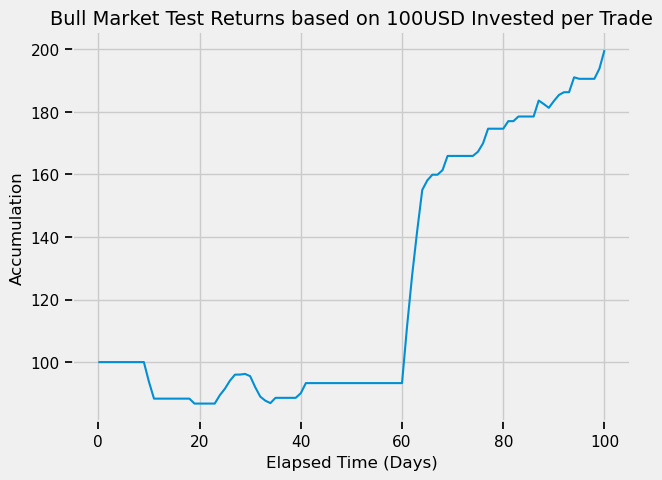

In [27]:
principal = 100
per_trade = 100
stance = [principal]
for i in range(len(changetest)):
    if ytest_pred[i]==1:
        profit = changetest[i]
        principal += per_trade*profit/100
        stance.append(principal)
    elif ytest_pred[i]==-1:
        profit = -changetest[i]
        principal+= per_trade*profit/100
        stance.append(principal)
    else:
        stance.append(principal)

print(principal)
plt.title('Bull Market Test Returns based on 100USD Invested per Trade',fontsize=14)
plt.xlabel('Elapsed Time (Days)')
plt.ylabel('Accumulation')
sns.lineplot(stance)
plt.show()

In [28]:
bull_model_performance = round(100*(stance[-1]-stance[0])/stance[0],2)
print('The model return is {}%'.format(bull_model_performance))

The model return is 99.77%


## Comparing Model Result to Benchmark of Buy and Hold

In [29]:
performance = round(100*(bull.loc[xtest.index[-1],'BTC Close']- bull.loc[xtest.index[0],'BTC Close'])/bull.loc[xtest.index[0],'BTC Close'],2)

print('The benchmark return is {}%'.format(performance))

The benchmark return is 42.25%


## Bear Model Training

We will now repeat the proceedure with the bear market

In [30]:
Xbear, ybear, changebear = feature_selection_bear(bear)

xtrain, xtest, ytrain, ytest, changetrain, changetest = train_test_split(Xbear,ybear,changebear,
                                                        train_size=0.7, random_state=0,shuffle=False)

In [31]:
# Initialize the model first in order to perform parameter hypertuning
model = RandomForestClassifier()
model.fit(xtrain,ytrain)

RandomForestClassifier()

### Parameter Hypertuning

In [32]:
tscv = TimeSeriesSplit(n_splits=10)

param_distributions = {'criterion': ('gini', 'entropy', 'log_loss'),
                       'max_depth': (15,25,35,50),
                       'max_features': ('sqrt','log2',None),
                       'max_samples': (0.6,0.7,0.8,0.9),
                       'min_samples_leaf': (1, 2, 3, 4),
                       'min_samples_split':(2, 4, 6, 8),
                       'class_weight': ({1:0.4,0:0.2,-1:0.4}, {1:0.35,0:0.3,-1:0.35},None)}

rs = RandomizedSearchCV(estimator=model,
                        param_distributions=param_distributions,
                        n_iter=200,
                        scoring='accuracy',
                        cv=tscv)
#rs.fit(xtrain, ytrain)

In [34]:
model_final = RandomForestClassifier(n_estimators=99,
                                     min_samples_split=4,
                                     min_samples_leaf=2,
                                     max_samples=0.85,
                                     max_features=None,
                                     max_depth=15,
                                     class_weight = None,
                                     criterion= 'entropy',
                                     bootstrap = True)
model_final.fit(xtrain, ytrain)

RandomForestClassifier(criterion='entropy', max_depth=15, max_features=None,
                       max_samples=0.85, min_samples_leaf=2,
                       min_samples_split=4, n_estimators=99)

In [35]:
print_importance(model_final, xtrain)

                 Feature  Importance
1               Diff SMA    0.219298
4     BTC Weekly Returns    0.204337
2      Meme Volume Ratio    0.195571
0             Median EMA    0.195455
3      BTC Open Interest    0.168960
7        lsr_transformed    0.009370
6        rsi_transformed    0.003807
9  shortliqs_transformed    0.003201
5       wmrs_transformed    0.000000
8   longliqs_transformed    0.000000


### Accuracy Score

In [36]:
ytrain_pred = model_final.predict(xtrain)
print(accuracy_score(ytrain, ytrain_pred))

0.9799196787148594


In [37]:
ytest_pred = model_final.predict(xtest)
print(accuracy_score(ytest, ytest_pred))

0.2777777777777778


### Profit Check

1559.1168741717215


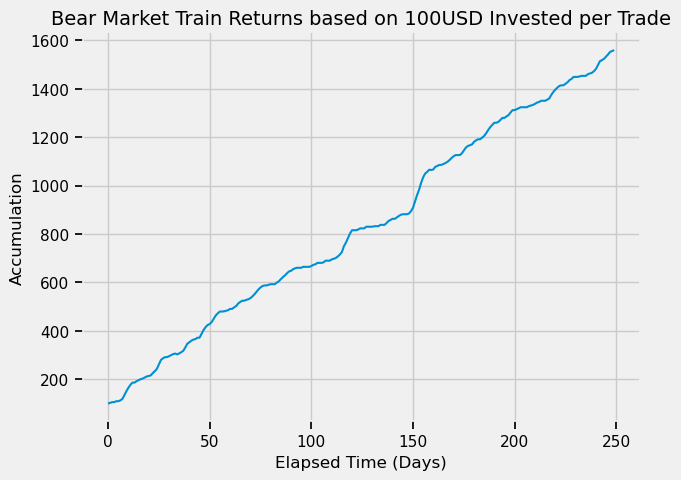

In [38]:
principal = 100
per_trade = 100
stance = [principal]
for i in range(len(changetrain)):
    if ytrain_pred[i]==1:
        profit = changetrain[i]
        principal += per_trade*profit/100
        stance.append(principal)
    elif ytrain_pred[i]==-1:
        profit = -changetrain[i]
        principal+= per_trade*profit/100
        stance.append(principal)
    else:
        stance.append(principal)

print(principal)
plt.title('Bear Market Train Returns based on 100USD Invested per Trade',fontsize=14)
plt.xlabel('Elapsed Time (Days)')
plt.ylabel('Accumulation')
sns.lineplot(stance)
plt.show()

173.56596503578137


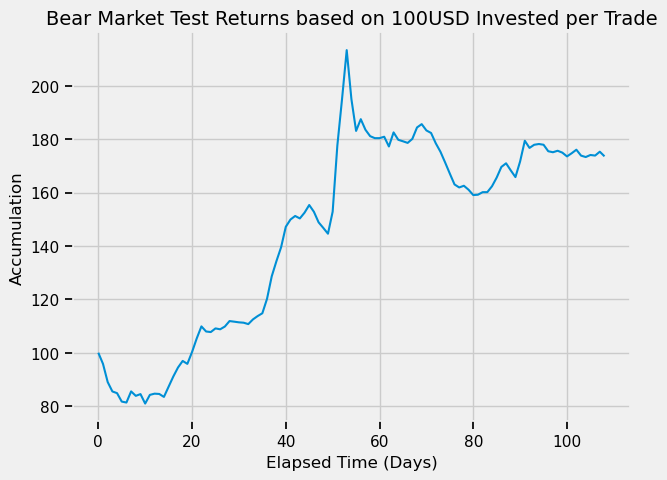

In [39]:
principal = 100
per_trade = 100
stance = [principal]
for i in range(len(changetest)):
    if ytest_pred[i]==1:
        profit = changetest[i]
        principal += per_trade*profit/100
        stance.append(principal)
    elif ytest_pred[i]==-1:
        profit = -changetest[i]
        principal+= per_trade*profit/100
        stance.append(principal)
    else:
        stance.append(principal)

print(principal)
plt.title('Bear Market Test Returns based on 100USD Invested per Trade',fontsize=14)
plt.xlabel('Elapsed Time (Days)')
plt.ylabel('Accumulation')
sns.lineplot(stance)
plt.show()

In [40]:
bear_model_performance = round(100*(stance[-1]-stance[0])/stance[0],2)
print('The model return is {}%'.format(bear_model_performance))

The model return is 73.57%


## Comparing Model Result to Benchmark of Buy and Hold

In [41]:
performance = round(100*(bear.loc[xtest.index[-1],'BTC Close']- bear.loc[xtest.index[0],'BTC Close'])/bear.loc[xtest.index[0],'BTC Close'],2)

print('The benchmark return is {}%'.format(performance))

The benchmark return is -16.01%
